# Atlantic Causal Inference Data Challenge 2019
[Official Site for the ACIC Data Challenge](https://sites.google.com/view/ACIC2019DataChallenge/data-challenge)

Quoting directly from the challenge website, here is a description of the data provided:

> Data are in the form (Y, A, V1, ... ,Vp), where 
> - Y is the outcome (either binary or continuous)
> - A is a binary treatment indicator
> - V1 through Vp are a mix of continuous, binary, and categorical pre-treatment covariates (no mediators). The number of covariates, p, varies across datasets.

The goal of the challenge is:

> Provide an estimate of the population average additive treatment effect (ATE) of a binary treatment on a binary or continuous outcome, and a 95% confidence interval. 

In [46]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.options.display.max_columns = 500

%matplotlib inline

Let's start by finding an easy dataset to work with by summarizing the target.

In [38]:
# summarize the low dimensional test datasets
summary = pd.DataFrame()
for f in os.listdir('TestDatasets_lowD'):
    if f.endswith('csv') and not f.endswith('cf.csv'):
        df = pd.read_csv(f'TestDatasets_lowD/{f}')
        summary[f] = df['Y'].describe()\
                            .append(pd.Series([df.shape], index = ['shape']))
        
display(summary)

,testdataset2.csv,testdataset3.csv,testdataset1.csv,testdataset4.csv,testdataset5.csv,testdataset7.csv,testdataset6.csv,testdataset8.csv
count,500,525,500,500,625,500,475,500
mean,17.9758,18.8849,0.3,0.268,0.3504,18.8151,17.5423,0.274
std,5.47596,12.6132,0.458717,0.443361,0.477477,12.4771,4.77874,0.446456
min,9.58147,-8.17043,0,0,0,1.09136,4.35973,0
25%,13.9635,9.14433,0,0,0,9.45514,14.2522,0
50%,16.9006,17.1066,0,0,0,16.3349,16.9655,0
75%,20.6377,26.6696,1,1,1,26.4147,19.797,1
max,45.1715,89.7877,1,1,1,81.8532,42.8032,1
shape,"(500, 24)","(525, 24)","(500, 24)","(500, 17)","(625, 24)","(500, 24)","(475, 24)","(500, 17)"


Of the 8 datasets, 4 are binary outcomes and 4 are continuous. Each dataset has roughly the same size (475-625 examples) and either 17 or 24 columns. Let's start with a regression case, so we don't have to deal with the added complexity of the logit (we'll get to that later). With that in mind, `testdataset3.csv` looks good.

In [48]:
df = pd.read_csv('TestDatasets_lowD/testdataset3.csv')
df['C'] = 1 # add a constant for regression intercept
df.describe()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,C
count,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.0
mean,18.884909,0.201905,0.294648,0.094381,0.109962,0.112857,0.090381,0.276038,0.067238,0.534876,0.112438,0.029410,0.077867,0.254495,0.171886,0.209486,1.712362,0.109067,0.827390,0.136914,0.112590,0.109010,0.548267,0.975067,1.0
std,12.613198,0.401804,0.522733,0.242423,0.337628,0.347767,0.298808,0.591365,0.206849,0.813346,0.368377,0.166184,0.340710,1.008381,0.534332,0.539255,1.802777,0.532904,1.248497,1.160294,0.395746,0.600167,1.730427,0.792503,0.0
min,-8.170434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,9.144325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.457425,1.0
50%,17.106626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.380000,0.000000,0.160000,0.000000,0.000000,0.000000,0.000000,0.809151,1.0
75%,26.669562,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.340000,0.000000,0.760000,0.000000,0.000000,0.000000,0.140000,0.000000,0.050000,2.610000,0.000000,1.350000,0.000000,0.000000,0.000000,0.000000,1.323887,1.0
max,89.787655,1.000000,3.220000,2.300000,2.530000,3.330000,3.330000,5.260000,2.000000,6.250000,5.550000,2.320000,2.380000,20.000000,5.060000,4.870000,12.500000,6.320000,10.710000,15.430000,4.760000,12.500000,16.660000,7.005336,1.0


Assuming a randomized, controlled trial, we can estimate the treatment effect $Y_i$ as a linear function of $A_i$:

$$Y_i = \beta_0 + \beta_1 A_i + u_i$$

where $A_i = 1$ if the subject was treated and $A_i = 0$ if not.

In [68]:
X = df[['A', 'C']]
y = df['Y']

model = sm.OLS(y, X)
fitted_model = model.fit()

print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     46.98
Date:                Sun, 17 Mar 2019   Prob (F-statistic):           2.02e-11
Time:                        22:49:29   Log-Likelihood:                -2052.6
No. Observations:                 525   AIC:                             4109.
Df Residuals:                     523   BIC:                             4118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
A              9.0124      1.315      6.854      0.0

Unsurprisingly, the $R^2$ is terrible. Our model estimated an average treatment effect (ATE) of 9.0124. Let's use our model to make predictions and test them against the counterfactuals in `testdataset3_cf.csv`.

In [73]:
test_results = pd.read_csv('TestDatasets_lowD/testdataset3_cf.csv')

test_results['EY1_i_pred'] = fitted_model.predict(pd.DataFrame({'A':np.ones(df.shape[0]),
                                                                'C':np.ones(df.shape[0])}))
test_results['EY0_i_pred'] = fitted_model.predict(pd.DataFrame({'A':np.zeros(df.shape[0]),
                                                                'C':np.ones(df.shape[0])}))
test_results['ATE_pred'] = test_results['EY1_i_pred'] - test_results['EY0_i_pred']

test_results.head()

,ATE,EY1_i,EY0_i,EY1_i_pred,EY0_i_pred,ATE_pred
0,2.090099,8.550162,7.550162,26.077697,17.065253,9.012444
1,2.090099,28.928069,27.928069,26.077697,17.065253,9.012444
2,2.090099,29.485588,30.693588,26.077697,17.065253,9.012444
3,2.090099,14.936482,13.142482,26.077697,17.065253,9.012444
4,2.090099,18.028003,17.028003,26.077697,17.065253,9.012444


Text(0.5,1,'Counterfactual vs. Predicted with Treatment')

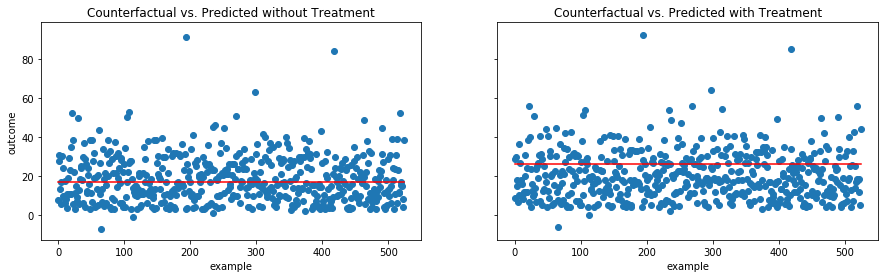

In [99]:
plt.rcParams["figure.figsize"] = (15,4)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(test_results.index, test_results['EY0_i'])
ax1.plot(test_results.index, test_results['EY0_i_pred'], color='red')
ax1.set_xlabel('example')
ax1.set_ylabel('outcome')
ax1.set_title('Counterfactual vs. Predicted without Treatment')

ax2.scatter(test_results.index, test_results['EY1_i'])
ax2.plot(test_results.index, test_results['EY1_i_pred'], color='red')
ax2.set_xlabel('example')
ax2.set_title('Counterfactual vs. Predicted with Treatment')

The population ATE (from `testdataset3_cf.csv`) is 2.09 while the predicted ATE is 9.01. This huge overstatement of the effect and the poor fit of the simple regression model indicate that the assumption of a randomized, controlled trial is likely false. Of course, this is expected given that we were provided with 22 features to use in addition to the treatment indicator.

This experiment was a helpful detour in understanding the causal inference process because we will use this basic model in assessing more complicated regression models. Next let's take a look at a multivariate regression.

The challenge description provides a few helpful details to aid our work:

> The causal parameter of interest is the population average additive treatment effect (ATE), $E[Y(1) - Y(0)]$. Causal assumptions of consistency and strong ignorability are guaranteed by the contest organizers, therefore the target statistical estimand equals $E[E(Y \mid A = 1, V) - E(Y \mid A = 0, V)]$, where $Y$ is the outcome, $A$ is a binary treatment indicator, and $V$ is a pre-treatment covariate vector containing all true confounders, and possibly additional variables related to either the outcome, treatment assignment, or neither. 